# Project: DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS

# Step 1: Import Essential Libraries 

In [1]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import os, json, math, joblib, requests
from pathlib import Path
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sqlalchemy import create_engine


# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem
----------------- TBC --------------------------


## 2.2 Inicitial Loading and Inspection

In [2]:
# 1. Johnny's Safety Reset
db_name = "supply_chain_logistics.db"
if os.path.exists(db_name):
    os.remove(db_name)
    print(f"Cleanup: Old {db_name} removed.")

# 2. Francisco's Clean Loading (DataCo specific)
# Note: Using latin1 encoding as required for this specific raw file
df = pd.read_csv('../data/raw/DataCoSupplyChainDataset.csv', encoding='latin1')

# Clean column names (removing spaces and special characters for SQL compatibility)
df.columns = [c.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '') for c in df.columns]


Cleanup: Old supply_chain_logistics.db removed.


# Step 3: Store the Information

In [3]:
# 3. Create fresh Engine and Table
engine = create_engine(f'sqlite:///{db_name}')
# 4. Define dataset variable through SQL
df.to_sql('supply_chain', engine, if_exists='replace', index=False)
print(f"Success! DataCo dataset loaded into a fresh SQL table. Shape: {df.shape}")

Success! DataCo dataset loaded into a fresh SQL table. Shape: (180519, 53)


# Step 4. Perform Descriptive Analysis
## 4.1 Data Dimensions & Types

In [4]:
# Basic shape and info
print(f"Dataset Shape: {df.shape}")
print("\nColumn Types:")
print(df.dtypes.value_counts())

Dataset Shape: (180519, 53)

Column Types:
str        24
float64    15
int64      14
Name: count, dtype: int64


## 4.2 Verifying the Data

In [5]:
# Display top 5 rows for dataset columns and data visibility
check_query = """ SELECT * FROM supply_chain"""
df_supply = pd.read_sql(check_query, engine)
print(tabulate(df_supply.head(), headers= "keys", tablefmt= "psql"))

+----+----------+--------------------------+-------------------------------+---------------------+----------------------+-------------------+----------------------+---------------+-----------------+-----------------+--------------------+------------------+------------------+---------------+------------------+---------------------+--------------------+------------------+--------------------------+--------------------+-----------------+-------------------+------------+-------------+--------------+--------------+-----------------+---------------------+-------------------------+------------+--------------------------+-----------------------+----------------------------+-----------------+----------------------------+---------------------------+-----------------------+---------+--------------------+--------------------------+----------------+-----------------+-----------------+-----------------+-------------------+-----------------------+-----------------------+------------------------------

In [6]:
# Check how the Shipping mode affects on late delivery risk
check_query = """
SELECT 
    Shipping_Mode,
    COUNT(*) as total_orders,
    ROUND(AVG(Late_delivery_risk), 3) as late_risk_rate,
    ROUND(AVG(Days_for_shipping_real), 2) as avg_actual_days
FROM supply_chain
GROUP BY Shipping_Mode
ORDER BY late_risk_rate DESC;
"""
df_results = pd.read_sql(check_query, engine)
print(df_results)

    Shipping_Mode  total_orders  late_risk_rate  avg_actual_days
0     First Class         27814           0.953             2.00
1    Second Class         35216           0.766             3.99
2        Same Day          9737           0.457             0.48
3  Standard Class        107752           0.381             4.00


### 4.2.1 Conclusion on Shippin Mode Difference
- We can confirm that Late_risk_rate ranges from 38% to 95%.
------------------------------------
Days Shippment Schedule:
| Shipping Mode | Schedule Days |
| --- | --- |
| **First Class** | 1 |
| **Second Class** | 2 |
| **Same Day** | 0 |
| **Standard Class** | 4 |

--------------------------------------------------------------------------------

| Shipping Mode | Risk Level | Avg. days | Comments |
| --- | --- | --- | --- |
| **First Class** | Very High | 2.00 | Unrealistic commitment on real days |
| **Second Class** | High | 3.99 | Significant delays |
| **Same Day** | Moderate | 0.48 | Highest delivery efficiency |
| **Standard Class** | Low | 4.00 | Easier delivery to commit |

## 4.3 Numerical Summary (The "Stats")

In [7]:
# 1. Statistical summary of key numerical columns
important_cols = ['Sales', 'Sales_per_customer', 'Late_delivery_risk', 'Days_for_shipping_real', 'Order_Item_Discount_Rate', 'Benefit_per_order']
desc_stats = df_supply[important_cols].describe()

# 2. Get the Mode for categorical predictors
categorical_cols = ['Shipping_Mode', 'Order_Region', 'Category_Name']
modes = df_supply[categorical_cols].mode().iloc[0]

print("--- Numerical Descriptive Stats ---")
print(tabulate(desc_stats, headers= "keys", tablefmt= "psql"))
print("\n--- Categorical Modes ---")
print(modes)

--- Numerical Descriptive Stats ---
+-------+------------+----------------------+----------------------+--------------------------+----------------------------+---------------------+
|       |      Sales |   Sales_per_customer |   Late_delivery_risk |   Days_for_shipping_real |   Order_Item_Discount_Rate |   Benefit_per_order |
|-------+------------+----------------------+----------------------+--------------------------+----------------------------+---------------------|
| count | 180519     |           180519     |        180519        |             180519       |             180519         |          180519     |
| mean  |    203.772 |              183.108 |             0.548291 |                  3.49765 |                  0.101668  |              21.975 |
| std   |    132.273 |              120.044 |             0.497664 |                  1.62372 |                  0.0704152 |             104.434 |
| min   |      9.99  |                7.49  |             0        |              

# Step 5: Perform a full EDA
## 5.1 Data Types and Non-Nulls Values Overview.

In [8]:
print("This is the information about Non-Null and Dtype:\n================================================")
df_supply.info()

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Type                         180519 non-null  str    
 1   Days_for_shipping_real       180519 non-null  int64  
 2   Days_for_shipment_scheduled  180519 non-null  int64  
 3   Benefit_per_order            180519 non-null  float64
 4   Sales_per_customer           180519 non-null  float64
 5   Delivery_Status              180519 non-null  str    
 6   Late_delivery_risk           180519 non-null  int64  
 7   Category_Id                  180519 non-null  int64  
 8   Category_Name                180519 non-null  str    
 9   Customer_City                180519 non-null  str    
 10  Customer_Country             180519 non-null  str    
 11  Customer_Email               180519 non-null  str    
 12  Customer_Fname     

### 5.1.1 Conclusion on Non-Nulls
1. The Missing Values (The "Small Gaps")
we have a few missing entries:
    - **Customer_Lname**: 8 missing values.
    - **Customer_Zipcode**: 3 missing values.
    - **Verdict**: Since these are so few, we can reviwe later if we could fill them with "Unknown" or 0 without hurting the model.

## 5.2 Check Unique

In [9]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df_supply.nunique())

These are the Unique Values for each columns on the Dataset:
Type                                4
Days_for_shipping_real              7
Days_for_shipment_scheduled         4
Benefit_per_order               21998
Sales_per_customer               2927
Delivery_Status                     4
Late_delivery_risk                  2
Category_Id                        51
Category_Name                      50
Customer_City                     563
Customer_Country                    2
Customer_Email                      1
Customer_Fname                    782
Customer_Id                     20652
Customer_Lname                   1109
Customer_Password                   1
Customer_Segment                    3
Customer_State                     46
Customer_Street                  7458
Customer_Zipcode                  995
Department_Id                      11
Department_Name                    11
Latitude                        11250
Longitude                        4487
Market                     

## 5.3 Check for Duplicates Values

In [10]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df_supply.duplicated().sum()
print(f"<< {duplicate_val} >> duplicated value in the dataset.")

<< 0 >> duplicated value in the dataset.


## 5.4 Duplicates Inspection

In [11]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df_supply[df_supply.duplicated(keep= False)]
print("Table with duplicates rows (in case they are and only for visibility):\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows (in case they are and only for visibility):
+--------+--------------------------+-------------------------------+---------------------+----------------------+-------------------+----------------------+---------------+-----------------+-----------------+--------------------+------------------+------------------+---------------+------------------+---------------------+--------------------+------------------+-------------------+--------------------+-----------------+-------------------+------------+-------------+----------+--------------+-----------------+---------------------+-------------------------+------------+--------------------------+-----------------------+----------------------------+-----------------+----------------------------+---------------------------+-----------------------+---------+--------------------+--------------------------+----------------+---------------+----------------+-----------------+-------------------+-----------------------+----

## 5.5 Drop Duplicates

In [12]:
# We will execute the code below to garantee no duplicates on the data set
df_supply = df_supply.drop_duplicates().reset_index(drop= True)
print(df_supply.shape)
print(tabulate(df_supply.head(), headers='keys', tablefmt='psql'))

(180519, 53)
+----+----------+--------------------------+-------------------------------+---------------------+----------------------+-------------------+----------------------+---------------+-----------------+-----------------+--------------------+------------------+------------------+---------------+------------------+---------------------+--------------------+------------------+--------------------------+--------------------+-----------------+-------------------+------------+-------------+--------------+--------------+-----------------+---------------------+-------------------------+------------+--------------------------+-----------------------+----------------------------+-----------------+----------------------------+---------------------------+-----------------------+---------+--------------------+--------------------------+----------------+-----------------+-----------------+-----------------+-------------------+-----------------------+-----------------------+-----------------

## 5.6 Eliminate Irrelevant Information

We have categorized the columns we should eliminate into three "Noise" groups:
1. Administrative IDs: Unique numbers that don't repeat (like Order_Id).
2. Redundant Identifiers: For instance, we have Category_Id and Category_Name; we only need the name (or the ID) for the model, not both.
3. Sensitive/PII Data: Emails and passwords have zero predictive power for logistics.

In [13]:
# List of column tha don't provide value for predicting delays
cols_to_drop = ['Category_Id', 'Customer_Email', 'Customer_Fname', 
                'Customer_Id', 'Customer_Lname', 'Customer_Password', 
                'Customer_Street', 'Department_Id', 'Order_Customer_Id', 
                'Order_Id', 'Order_Item_Cardprod_Id', 'Order_Item_Id', 
                'Order_Zipcode', 'Product_Card_Id', 'Product_Image', 
                'Product_Description', 'Product_Status', 'order_date_DateOrders', 
                'Product_Category_Id', 'Order_Item_Cardprod_Id']

# Code to drop the columns
df_supply = df_supply.drop(columns= cols_to_drop)
print(f"Columns Removed: {len(cols_to_drop)}")
print(f"Remaining Columns: {df_supply.shape[1]}")

Columns Removed: 20
Remaining Columns: 34


## 5.7 Checking Hidden Missing Values

Zero counts per column:
Type: 0 zeros
Days_for_shipping_real: 5080 zeros
Days_for_shipment_scheduled: 9737 zeros
Benefit_per_order: 1177 zeros
Sales_per_customer: 0 zeros
Delivery_Status: 0 zeros
Late_delivery_risk: 81542 zeros
Category_Name: 0 zeros
Customer_City: 0 zeros
Customer_Country: 0 zeros
Customer_Segment: 0 zeros
Customer_State: 0 zeros
Customer_Zipcode: 0 zeros
Department_Name: 0 zeros
Latitude: 0 zeros
Longitude: 0 zeros
Market: 0 zeros
Order_City: 0 zeros
Order_Country: 0 zeros
Order_Item_Discount: 10028 zeros
Order_Item_Discount_Rate: 10028 zeros
Order_Item_Product_Price: 0 zeros
Order_Item_Profit_Ratio: 1177 zeros
Order_Item_Quantity: 0 zeros
Sales: 0 zeros
Order_Item_Total: 0 zeros
Order_Profit_Per_Order: 1177 zeros
Order_Region: 0 zeros
Order_State: 0 zeros
Order_Status: 0 zeros
Product_Name: 0 zeros
Product_Price: 0 zeros
shipping_date_DateOrders: 0 zeros
Shipping_Mode: 0 zeros


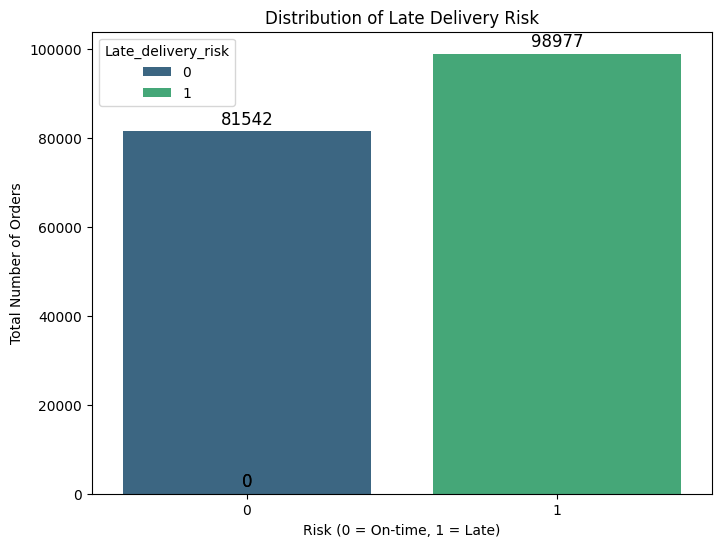

In [14]:
# 1. Check for 'Hidden' missing values
# Columns where a 0 is or could be impossible
cols_to_fix = df_supply.columns

print("Zero counts per column:")
for col in cols_to_fix:
    print(f"{col}: {(df_supply[col] == 0).sum()} zeros")

# 2. Visualize the Class Imbalance (Late_delivery_risk)
target = 'Late_delivery_risk'
plt.figure(figsize= (8,6))
ax = sns.countplot(x= target, data= df_supply, hue= target, palette= 'viridis')
plt.title('Distribution of Late Delivery Risk')
plt.xlabel('Risk (0 = On-time, 1 = Late)')
plt.ylabel('Total Number of Orders')

# Adding the exact count on top of bars
for x in ax.patches:
    ax.annotate(f'{int(x.get_height())}', (x.get_x() + x.get_width() / 2., x.get_height()), 
                ha= 'center', va= 'baseline', fontsize= 12, color= 'black', xytext= (0, 5),
                textcoords= 'offset points')
plt.show()

### 5.7.1 Conclusion on Hidden Values (those zeros) & Imbalance Target Chart
1. The "Natural" Zeros (Safe to keep)
These zeros make perfect sense in a business context:
    - Late_delivery_risk (81,542): These are just the orders that were on time.
    - Order_Item_Discount & Rate (10,028): These represent orders where no discount was applied.
2. The Warning Zeros (Investigate or Drop)
These are the ones that require your attention:
    - Product_Status (180,519): Every single row is 0. This column provides zero information (zero variance). We should drop this immediately as it's a "dead" column.
    - Days_for_shipping_real (5,080): A zero here implies the item was delivered the same day it was ordered.
        - Check: Cross the reference this with Shipping_Mode == 'Same Day'. If they match, the zeros are real.
    - Benefit_per_order / Order_Profit_Per_Order (1,177): These are orders where the company made exactly $0.00 profit. This is possible (break-even).
3. The Suspicious Zeros
    - Days_for_shipment_scheduled (9,737): This likely represents "Express" or "Same Day" shipping. Maybe the delivery was in a milk-run at a local area.

## 5.8 Categoric Variable Analysis

In [15]:
# 1. Convert the object column to a proper datetime format
df_supply['shipping_date_DateOrders'] = pd.to_datetime(df_supply['shipping_date_DateOrders'])

In [16]:
 # Only columns with object or str data type (categoric)
categorics = df_supply.select_dtypes(include= ['object','string']).columns.tolist()
print(f"Categorics variables: {categorics}")

Categorics variables: ['Type', 'Delivery_Status', 'Category_Name', 'Customer_City', 'Customer_Country', 'Customer_Segment', 'Customer_State', 'Department_Name', 'Market', 'Order_City', 'Order_Country', 'Order_Region', 'Order_State', 'Order_Status', 'Product_Name', 'Shipping_Mode']


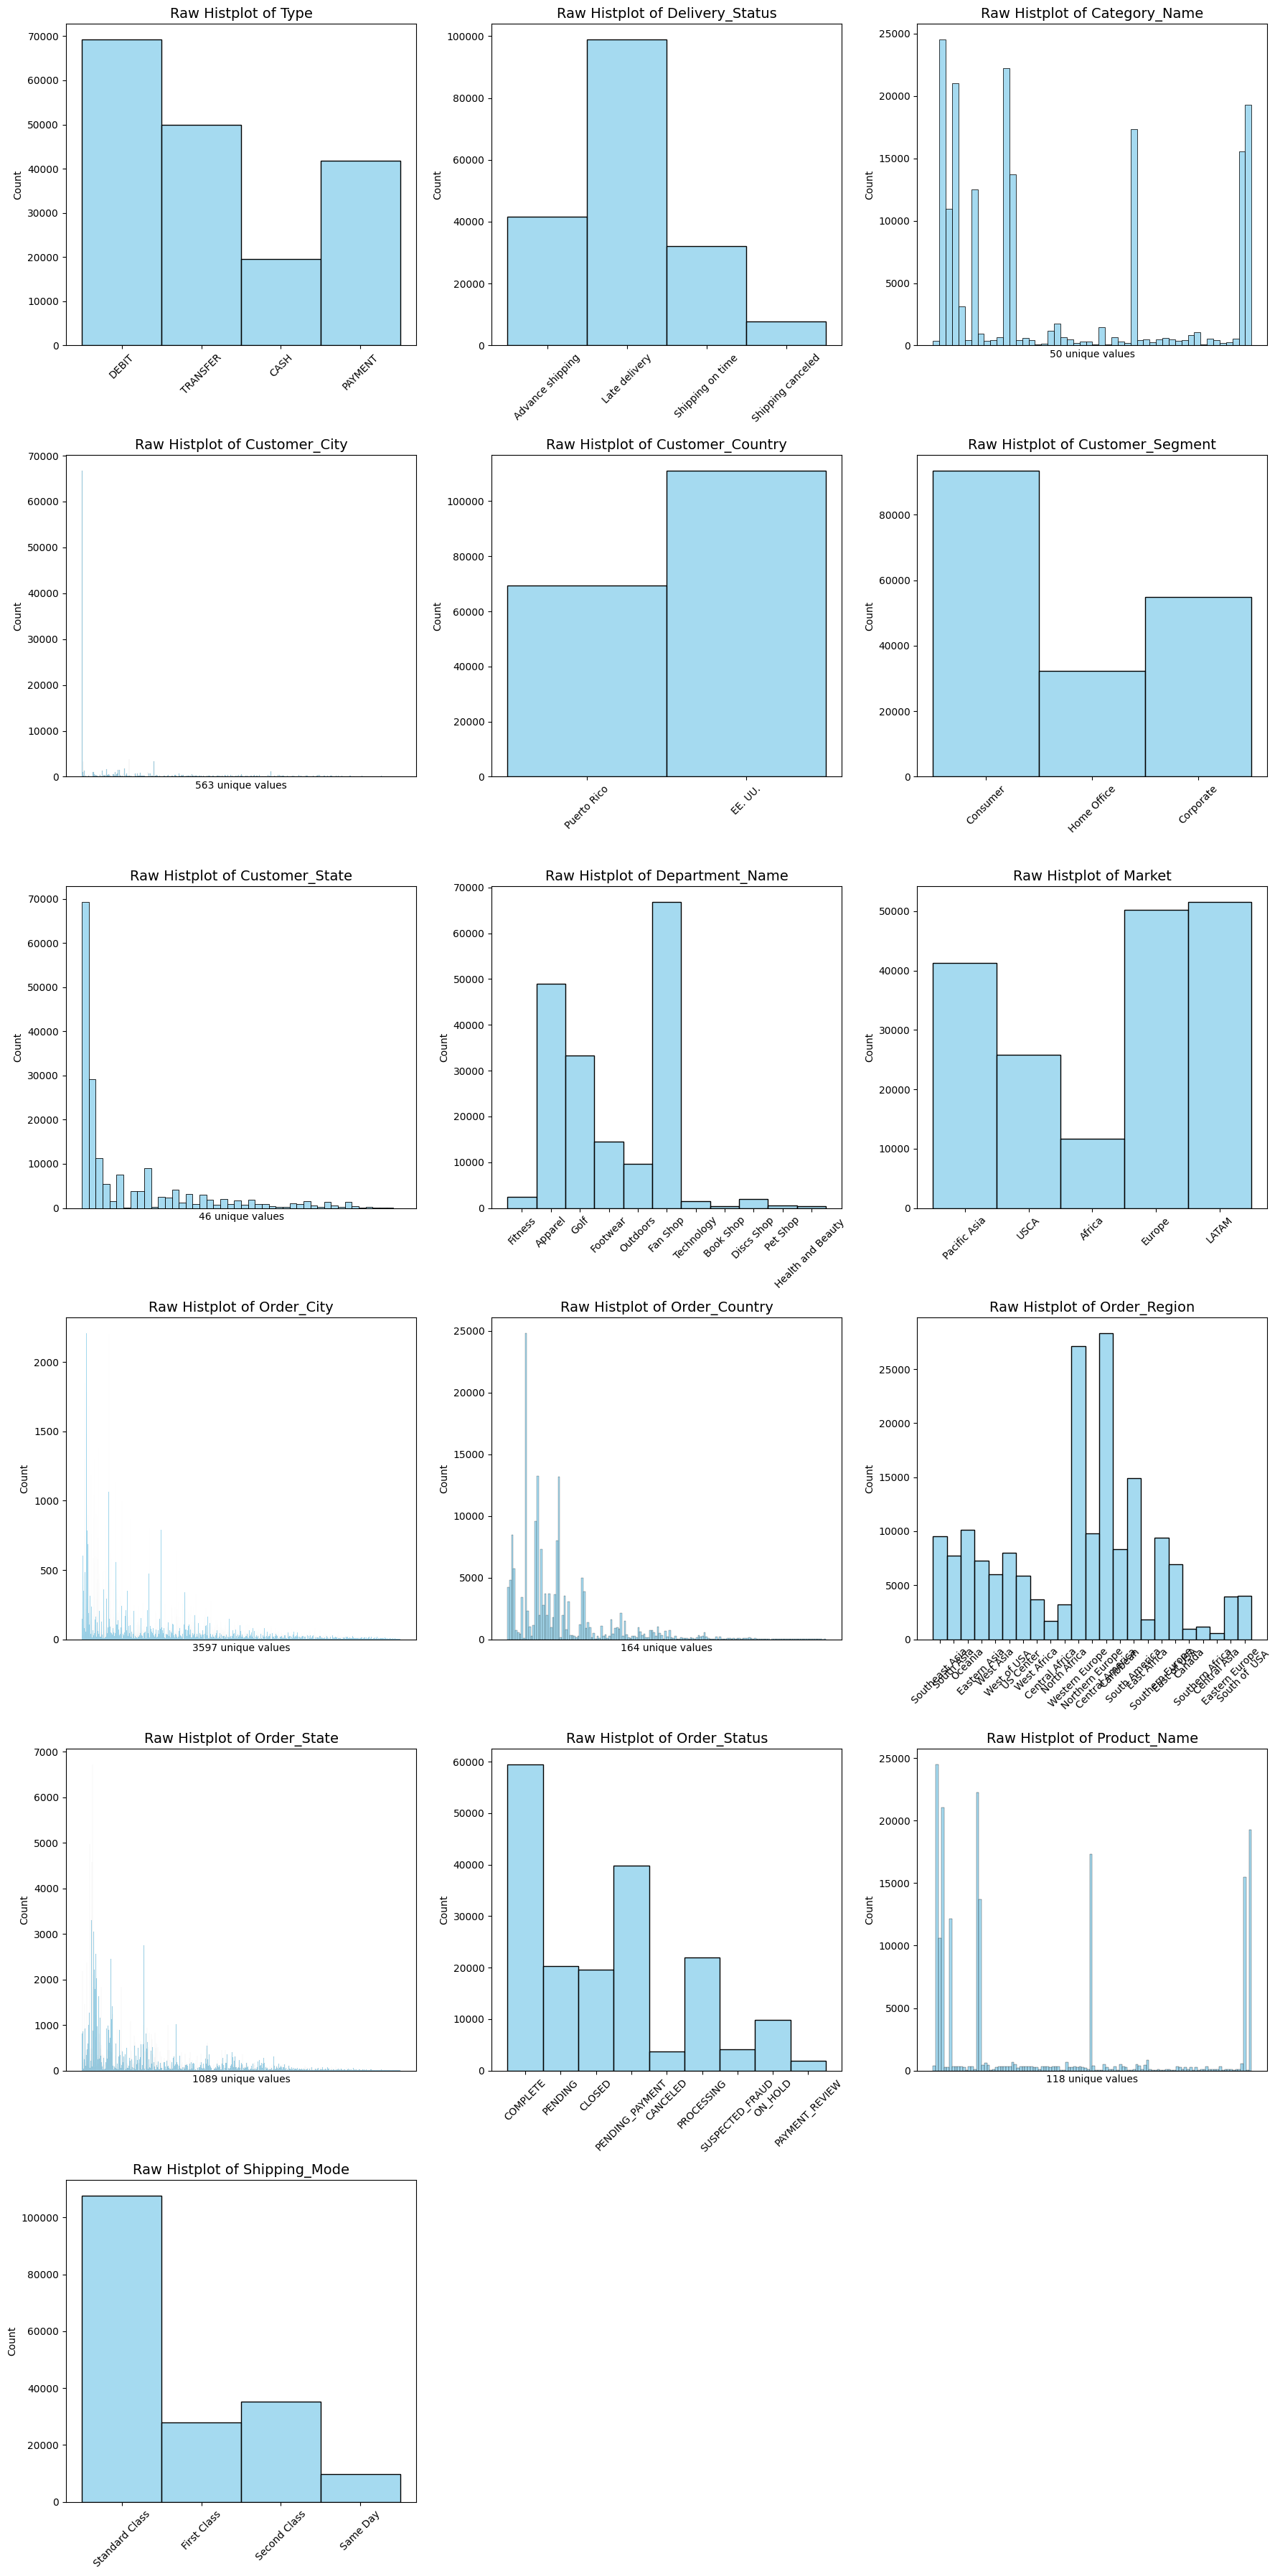

In [17]:
# 1. Set up the grid
n_cols = 3
n_rows = math.ceil(len(categorics) / n_cols)
fig, axis = plt.subplots(n_rows, n_cols, figsize= (18, 6 * n_rows))
axis = axis.flatten()

# 2. Integrate plots with automatic logic
for i, col in enumerate(categorics):
    # Plotting
    sns.histplot(ax= axis[i], data= df_supply, x= col, color= 'skyblue')

    axis[i].set_title(f'Raw Histplot of {col}', fontsize= 14)
    axis[i].set_xlabel('')

    # Hide the X labels if there are more than 20 values
    if df_supply[col].nunique() > 25:
        axis[i].set_xticks([])                          
        axis[i].set_xlabel(f"{df_supply[col].nunique()} unique values")
    else:
        axis[i].tick_params(axis= 'x', rotation= 45)

# Remove extra empty plot or grid
for j in range(len(categorics), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()



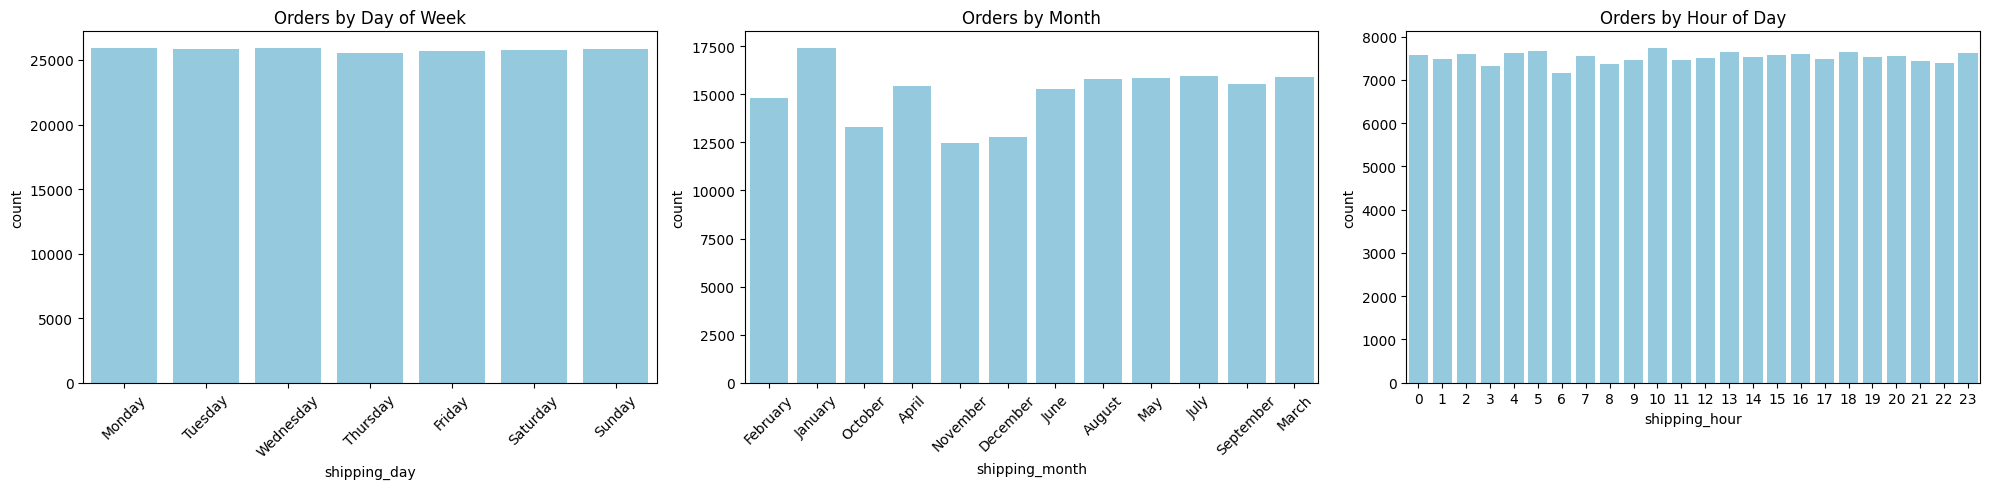

In [18]:
# 1. We have converted the object column to a proper datetime format above
# 2. Extract new features
df_supply['shipping_day'] = df_supply['shipping_date_DateOrders'].dt.day_name()
df_supply['shipping_month'] = df_supply['shipping_date_DateOrders'].dt.month_name()
df_supply['shipping_hour'] = df_supply['shipping_date_DateOrders'].dt.hour

# 3. Plot the new clean distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(ax= axes[0], data= df_supply, x= 'shipping_day', color= 'skyblue',
              order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0].set_title('Orders by Day of Week')
axes[0].tick_params(axis= 'x', rotation= 45)

sns.countplot(ax= axes[1], data= df_supply, x= 'shipping_month', color= 'skyblue',)
axes[1].set_title('Orders by Month')
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(ax= axes[2], data= df_supply, x= 'shipping_hour', color= 'skyblue',)
axes[2].set_title('Orders by Hour of Day')

plt.tight_layout()
plt.show()

### 5.8.1 Conclusions for Categorical Variable Charts
------------------ TBC ------------------------------

## 5.9 Numeric Variable Analysis

In [19]:
# Select only columns with 'int or float' data type (numeric)
numerics = df_supply.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['Days_for_shipping_real', 'Days_for_shipment_scheduled', 'Benefit_per_order', 'Sales_per_customer', 'Late_delivery_risk', 'Customer_Zipcode', 'Latitude', 'Longitude', 'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Product_Price', 'Order_Item_Profit_Ratio', 'Order_Item_Quantity', 'Sales', 'Order_Item_Total', 'Order_Profit_Per_Order', 'Product_Price', 'shipping_hour']


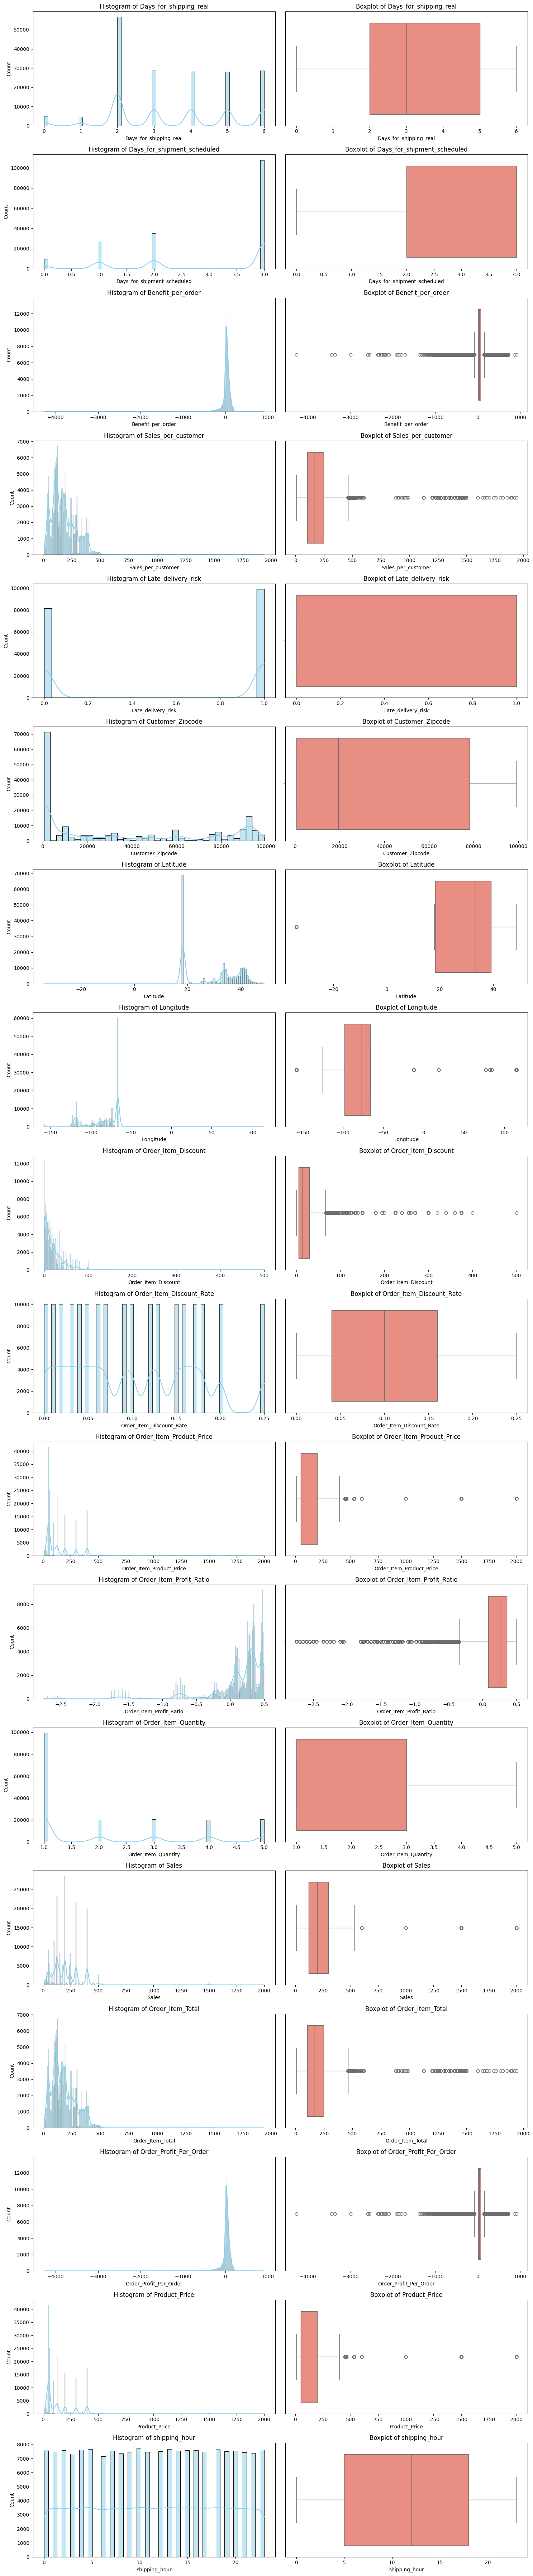

In [20]:
# Creating histplot and boxplot for the numeric variables
if len(numerics) != 0:
    nrows = len(numerics)
    ncols = 2
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(15, 4 * nrows))

    for i, col in enumerate(numerics):
        sns.histplot(df_supply[col], kde= True, ax= axes[i, 0], color= "skyblue")
        axes[i, 0].set_title(f'Histogram of {col}')
        sns.boxplot(x= df_supply[col], ax= axes[i, 1], color= "salmon")
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()
else:
    print("There are no numercial variables or the list numerics might be empty")

### 5.8.1 Conclusions for Numerical Variable Charts
We want to share only key observations on the charts.
- **The "Gap" Distributions**: Days_for_shipping_real vs. Days_for_shipment_scheduled. Notice how the scheduled days have very specific "peaks" (discrete values), while the real days are more spread out.
- **The Profit Outliers**: The boxplot for Benefit_per_order and Order_Profit_Per_Order shows a very long "tail" of dots on the left side. They are extreme points that the model should help investigate.
- **The Skewed Revenue**: The Sales and Sales_per_customer histograms show a sharp peak on the left with a long tail to the right.
- **The Balanced Target**: The separate count plot for Late_delivery_risk is beautiful. It clearly shows the class balance, which is the "green light" to proceed with standard ML algorithms.

## 5.9 Categorical-Categorical Analysis (Multivariate Variables Analysis)

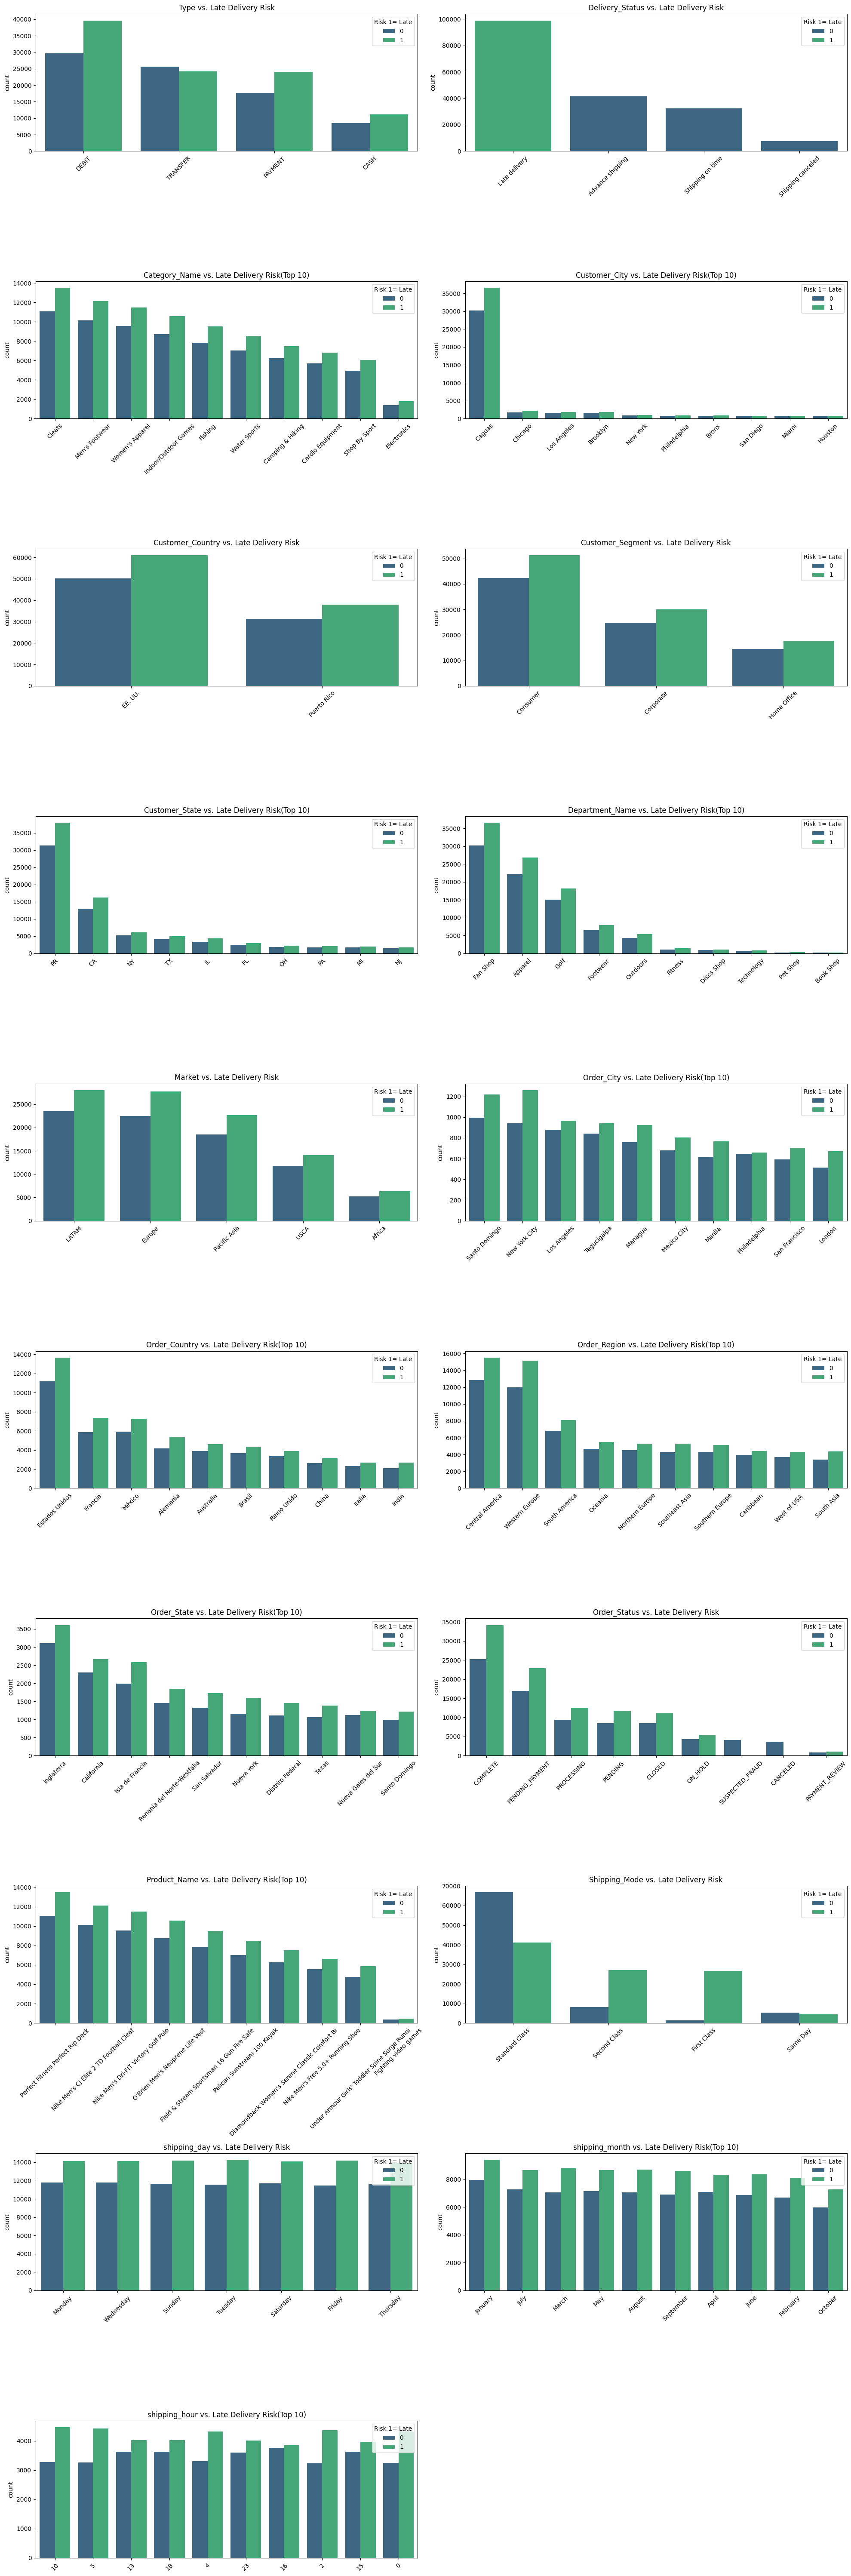

In [21]:
# List of categorical including the new features
# Excluding the raw shipping_date sice we transformed it
cols_to_plot = [c for c in categorics if c != 'shipping_date_DateOrders'] +  \
               ['shipping_day', 'shipping_month', 'shipping_hour']
# 1. Set up Grid
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)
fig, axis = plt.subplots(n_rows, n_cols, figsize= (20, 6 * n_rows))
axis = axis.flatten()

# 2. Loop through the columns and plot with the 'Late_delivery_risk' class as hue
for i, col in enumerate(cols_to_plot):
    # For high cardinality columns, only plot the top 10 to keep it readable
    if df_supply[col].nunique() > 10:
        top_10 = df_supply[col].value_counts().nlargest(10).index
        plot_data = df_supply[df_supply[col].isin(top_10)]
        title_suffix = "(Top 10)"
    else:
        plot_data = df_supply
        title_suffix = ""

    # Plotting with bars sorted by total count for better readability
    order = plot_data[col].value_counts().index
    sns.countplot(ax= axis[i], data= plot_data, x= col, hue= 'Late_delivery_risk', palette= 'viridis', order= order)
    axis[i].set_title(f'{col} vs. Late Delivery Risk{title_suffix}')
    axis[i].set_xlabel('')
    axis[i].legend(title= 'Risk 1= Late', loc= 'upper right')
    axis[i].tick_params(axis= 'x', rotation= 45)

# 3. Final clean up of the grid
for j in range(len(cols_to_plot), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

### 5.9.1 Conclusion Cat - Cat Analysis
- **Type vs. Risk**: "DEBIT" and "TRANSFER" payments seem to have a higher volume of late deliveries compared to "CASH" or "PAYMENT"
- **Delivery Status vs. Risk**: We can see that the "Late Delivery" is 100% late and there is no blue bar. This is Delivery_Status is a duplicate of Late_delivery_risk.
- **Category_Name vs Risk**: High volume items like **Cleats**, **Men's Footwear**, and **Women's Apparel** dominate the late delivery counts.
- **Customer_Country vs Risk**: Puerto Rico shows a massive volume of late deliveries compared to the US. This is a critical geographical signal for your model.
- **Market vs Risk**: Europe and LATAM show the highest volume of late deliveries. This suggests that regional infrastructure or distance from warehouses in these areas is a major delay driver.
- **Order_Status vs Risk**: COMPLETE and PENDING statuses are heavily associated with risk. Conversely, CLOSED orders have a much healthier ratio, suggesting they are processed more successfully.
- **Shipping_Mode vs Risk**: This is the most significant "Predictor". First Class and Second Class have a disproportionately high green bar (Late) compared to blue (On Time).
- **Shipping_Day vs Risk**: Despite volumes being equal across the week, the risk of delay is consistently high every day. There is no "safe day" to ship in this dataset.
- **Shipping_Month vs Risk**: Risk peaks in January (post-holiday backlog) and May (seasonal peak). In contrast, October through December shows a significant decline in activity.


## 5.10 Numerical-Numerical Analysis (Multivariate Variables Analysis)

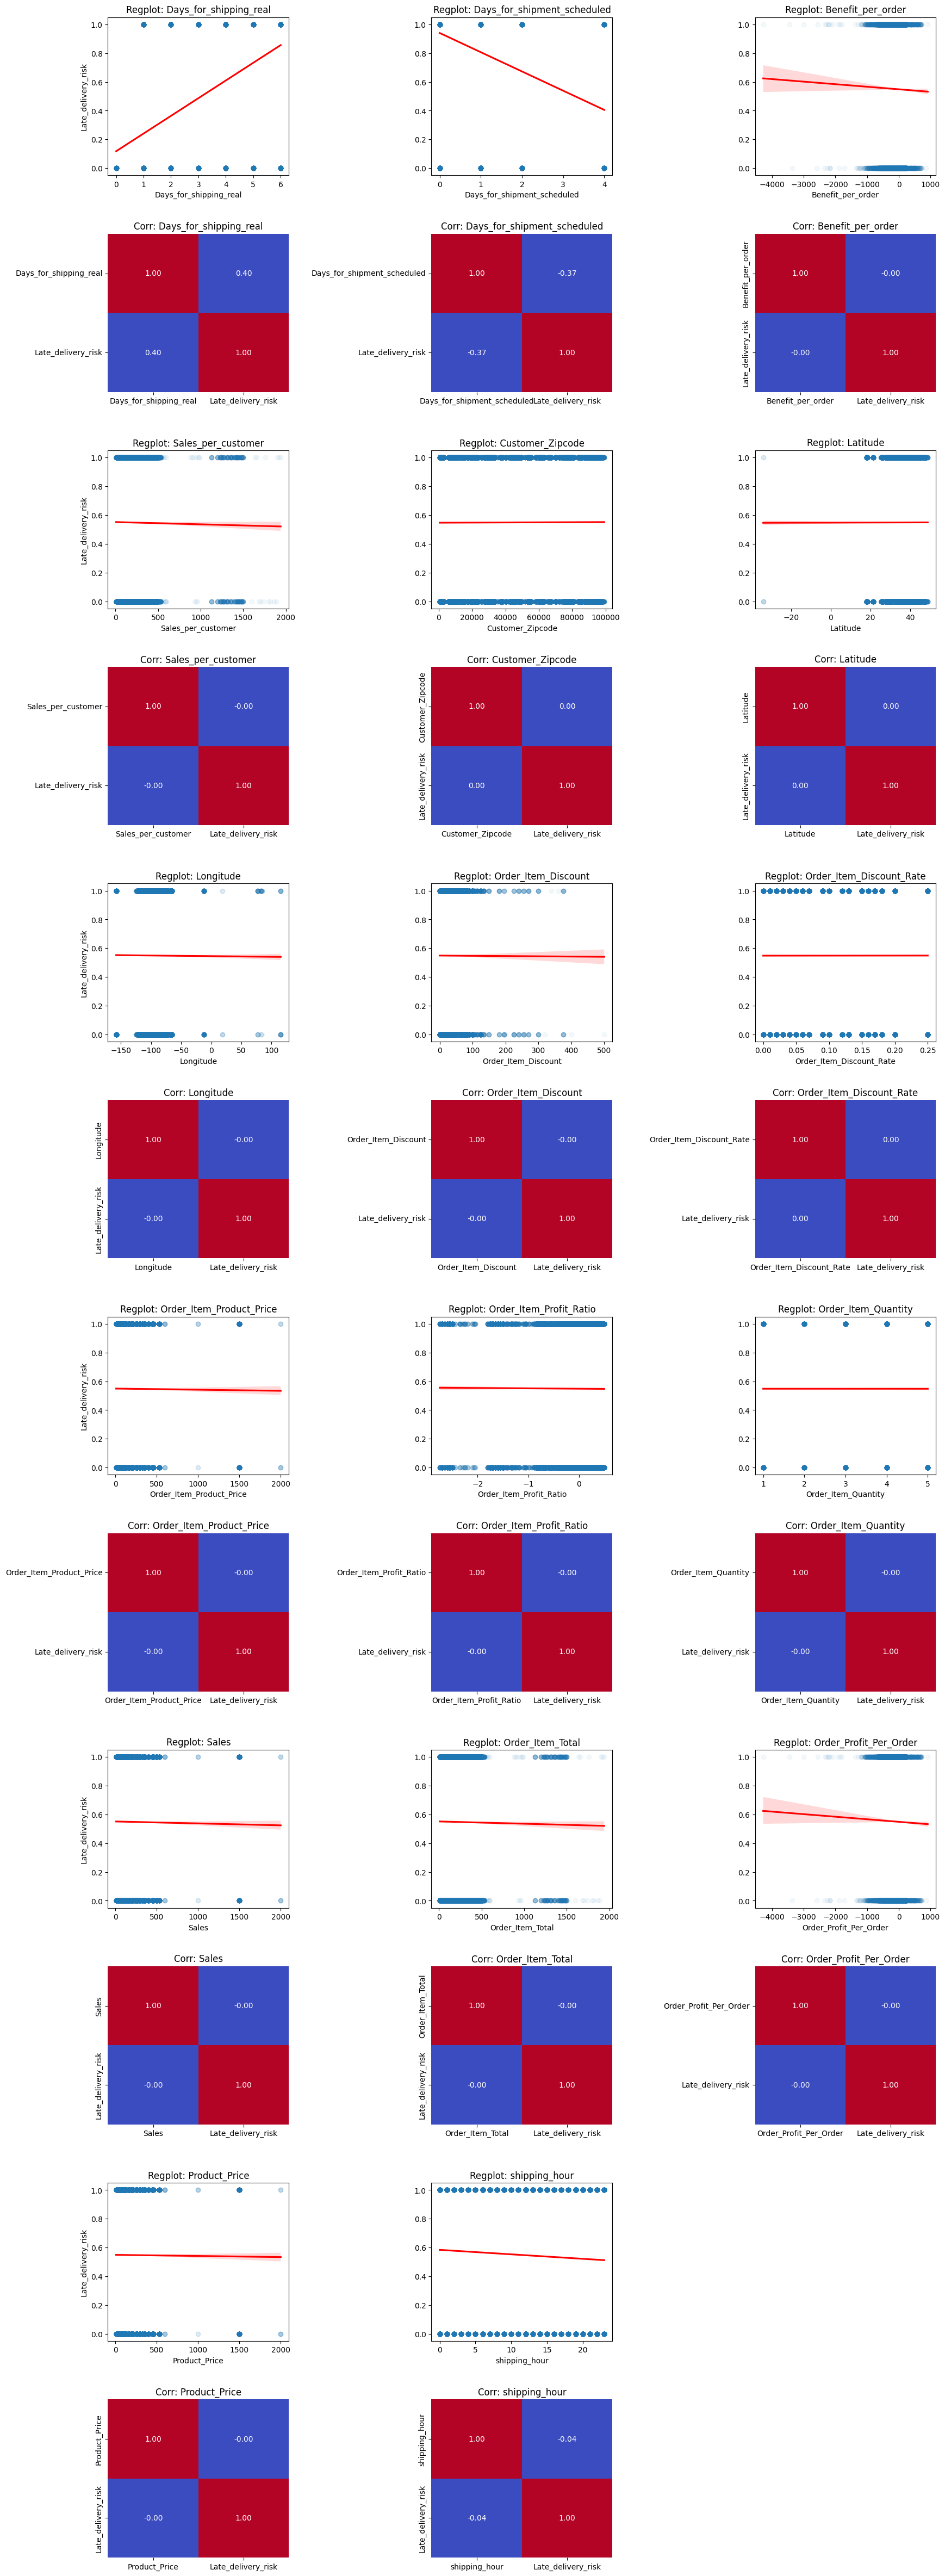

In [22]:
# 1. Excluding the target. The condition is to avoid ploting the target with itself.
if 'Late_delivery_risk' in numerics: numerics.remove('Late_delivery_risk')
target_num = 'Late_delivery_risk'

# 2. Calculate Grid Size
ncols = 3
group_chart = math.ceil(len(numerics) / ncols)
nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (18, 4 * nrows))

for chart_idx in range(group_chart):
    # Determine which row we are on for Regplots
    reg_row = chart_idx * 2
    # The Heatmap row is always the one right below it
    heat_row = reg_row + 1

    # Get the 3 variables for this group
    start = chart_idx * ncols
    end = start + ncols
    current_vars = numerics[start:end]

    for col_idx, col in enumerate(current_vars):
        # --- Plot 1: Regplot ---
        sns.regplot(data= df_supply, x= col, y= target_num, ax= axes[reg_row, col_idx], scatter_kws= {'alpha':0.05}, line_kws= {'color':'red'})
        axes[reg_row, col_idx].set_title(f'Regplot: {col}')
        if col_idx > 0:
            axes[reg_row, col_idx].set(ylabel= None)
        # --- Plot 2: Heatmap ---
        sns.heatmap(df_supply[[col, target_num]].corr(), annot= True, fmt= ".2f", ax= axes[heat_row, col_idx], cmap= 'coolwarm', cbar= False)
        axes[heat_row, col_idx].set_title(f'Corr: {col}')
# 4. Hide empty slots (if any)
for col_idx in range(len(current_vars), ncols):
    axes[reg_row, col_idx].set_visible(False)
    axes[heat_row, col_idx].set_visible(False)


plt.tight_layout(pad= 3.0)
plt.show()

### 5.10.1 Num - Num Conclusion
* Let's see what those charts are telling us about thouse features or variables.
1. **The Logic Predictors: Shipping Days**
    - **Observation**: Days_for_shipping_real shows a nearly perfect positive correlation with the target. As actual shipping time increases, the risk of a late delivery becomes a certainty.
    - **Observation**: Days_for_shipment_scheduled shows a negative correlation. This indicates that orders with more generous planned delivery windows are significantly less likely to result in a late status.
2. **The Financial Indicators: Profit & Sales**
    - **Observation**: Benefit_per_order and Sales show very flat regression lines. This means that whether an order is highly profitable or a high-revenue sale, it doesn't necessarily change the probability of it being late.
    - **Observation**: The distribution of Benefit_per_order contains extreme negative outliers (losses over $4,000), suggesting that while profit doesn't predict lateness, lateness might be causing these financial cost impact.
3. **Geographical & Order Metrics**
    - **Observation**: Latitude, Longitude, and Order_Item_Quantity show near-zero correlation with Late_delivery_risk.
    - **Insight**: The physical location of the customer or the size of the order (quantity) are not the primary drivers of delays in this specific supply chain.

* **Decision for Modeling**:
- We must exclude Days_for_shipping_real from the training features to avoid Data Leakage, as this value is only known after the event has occurred.
- We should focus on Days_for_shipment_scheduled, Shipping_Mode, and Order_Region as our primary predictors.
- The presence of extreme outliers in Benefit_per_order justifies our previous decision to handle high-earners/outliers separately to prevent model distortion.

## 5.11 Num - Num Analysis

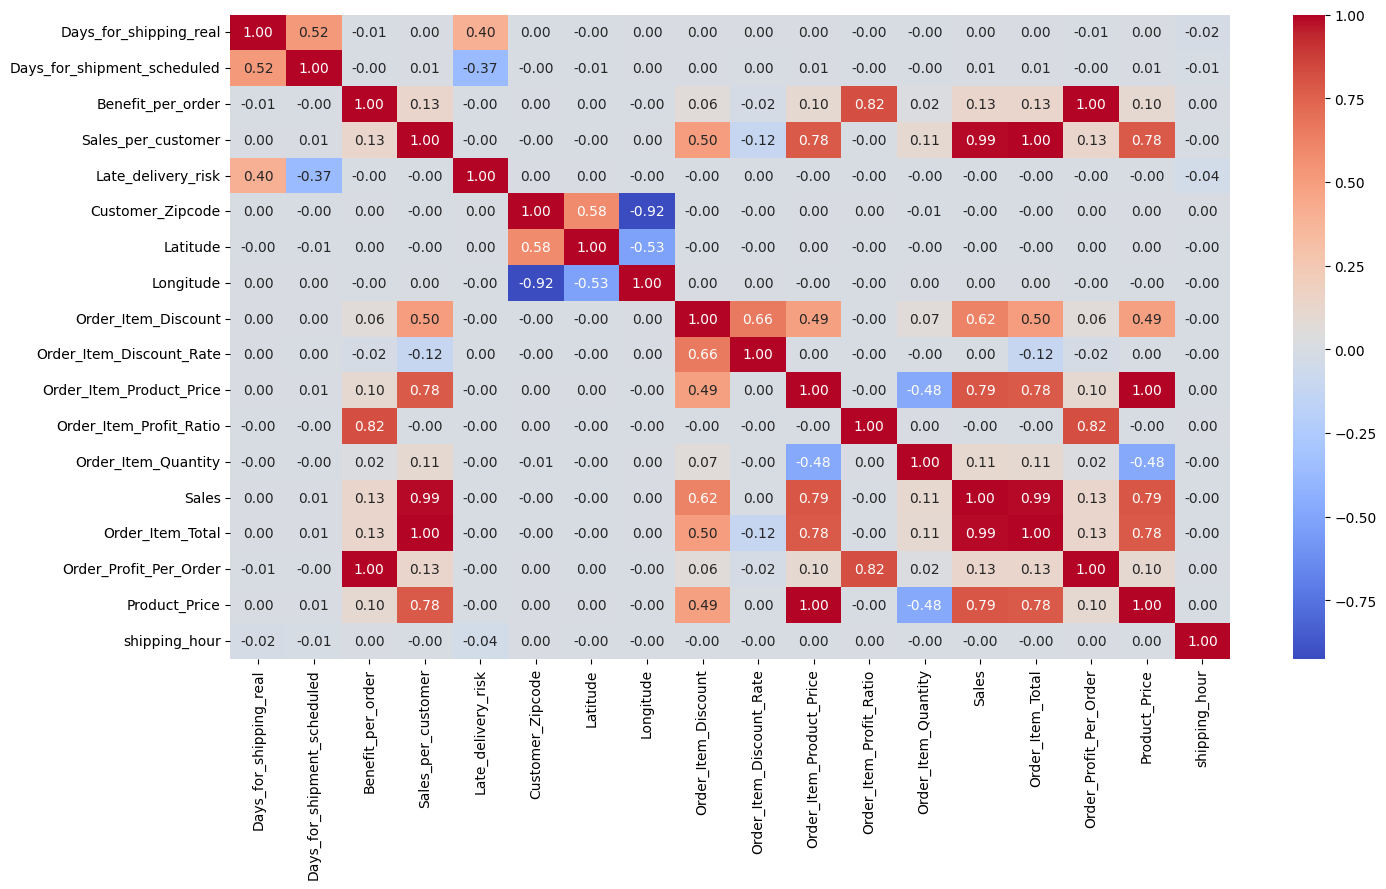

In [23]:
# Creating heatmap chart to analyze complete variables correlation
cols_num = df_supply.select_dtypes(include= ['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_supply[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "coolwarm", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()

### 5.11.1 Conclusion Correlation Heatmap

* Let’s review the information from our correlation chart and draw some conclusions:

    1. **Correlations of 0.99 – 1.00:**  
        - Sales <-> Order_Item_Total (~0.99) **--> Drop Order_Item_Total**
        - Sales <-> Sales_per_customer (~0.99) **--> Drop Sales_per_customer**
        - Product_Price <-> Order_Item_Product_Price (~1.00) **--> Drop Order_Item_Product_Price**
        - Benefit_per_order <-> Order_Profit_Per_Order (~1.00) **--> Drop Order_Profit_Per_Order**  
        - Order_Item_Total <-> Sales_per_customer  (~1.00) **--> Drop both**
        - Order_Item_Profit_Ratio <-> Benefit_per_order (0.82): **--> Drop Order_Item_Profit_Ratio**
        - Customer_Zipcode <-> Longitude (-0.92): **--> Drop Customer_Zipcode**

    **Conclusion**: Redundant variables. In predictive models, this may cause multicollinearity.  
    **Recommendation**: Remove one variable from each pair when modeling.  

    2. **Strong Sales Relationship**:   

        - Sales <-> Order_Item_Product_Price (~0.79)  
        - Sales <-> Order_Item_Discount (~0.62)  
        - Sales <-> Order_Item_Total (~1.00)  

    **Conclusion**: Discounts show a positive correlation with sales; likely, when higher discounts are applied, sales volume increases.  
  
    3. **Shipping and Late Delivery Risk:**  

        - Days_for_shipping_real <-> Days_for_shipment_scheduled (~0.52): Moderately correlated. **-->Drop Days_for_shipping_real** LEAKAGE: We drop real because it contains the answer to whether the order is late.
        - Days_for_shipping_real <-> Late_delivery_risk (~0.40): More actual shipping days increase the risk of delay.  
        - Days_for_shipment_scheduled <-> Late_delivery_risk (-0.37): When the scheduled shipping time is longer, the risk decreases. This may indicate that planning with a larger time buffer reduces delays.  

## 5.12 Numerical- Categorical Analysis (complete)


**final_cols_base** = ['Days_for_shipment_scheduled',
 'Benefit_per_order',
 'Delivery_Status',
 'Late_delivery_risk',
 'Category_Name',
 'Customer_City',
 'Customer_Country',
 'Customer_Segment',
 'Customer_State',
 'Department_Name',
 'Latitude',
 'Longitude',
 'Market',
 'Order_City',
 'Order_Country',
 'Order_Item_Discount',
 'Order_Item_Discount_Rate',
 'Order_Item_Quantity',
 'Sales',
 'Order_Region',
 'Order_State',
 'Order_Status',
 'Product_Name',
 'Product_Price',
 'Shipping_Mode',
 'shipping_day',
 'shipping_month',
 'shipping_hour']

In [34]:
# Shaping the dataset with final_cols_base defined before to be used in the next steps of the project
final_cols_base = ['Days_for_shipment_scheduled', 'Benefit_per_order', 'Delivery_Status', 'Late_delivery_risk', 'Category_Name', 
                   'Customer_City', 'Customer_Country', 'Customer_Segment', 'Customer_State', 'Department_Name', 'Latitude', 'Longitude', 
                   'Market', 'Order_City', 'Order_Country', 'Order_Item_Discount', 'Order_Item_Discount_Rate', 'Order_Item_Quantity',
                   'Sales', 'Order_Region', 'Order_State', 'Order_Status', 'Product_Name', 'Product_Price', 'Shipping_Mode', 'shipping_day',
                   'shipping_month', 'shipping_hour']
df_supply = df_supply[final_cols_base]
print(f"Dataset reshaped to {df_supply.shape} with selected columns for modeling.")
print(tabulate(df_supply.head(), headers= "keys", tablefmt= "psql"))   


Dataset reshaped to (180519, 28) with selected columns for modeling.
+----+-------------------------------+---------------------+-------------------+----------------------+-----------------+-----------------+--------------------+--------------------+------------------+-------------------+------------+-------------+--------------+--------------+-----------------+-----------------------+----------------------------+-----------------------+---------+----------------+-----------------+-----------------+----------------+-----------------+-----------------+----------------+------------------+-----------------+
|    |   Days_for_shipment_scheduled |   Benefit_per_order | Delivery_Status   |   Late_delivery_risk | Category_Name   | Customer_City   | Customer_Country   | Customer_Segment   | Customer_State   | Department_Name   |   Latitude |   Longitude | Market       | Order_City   | Order_Country   |   Order_Item_Discount |   Order_Item_Discount_Rate |   Order_Item_Quantity |   Sales | Order

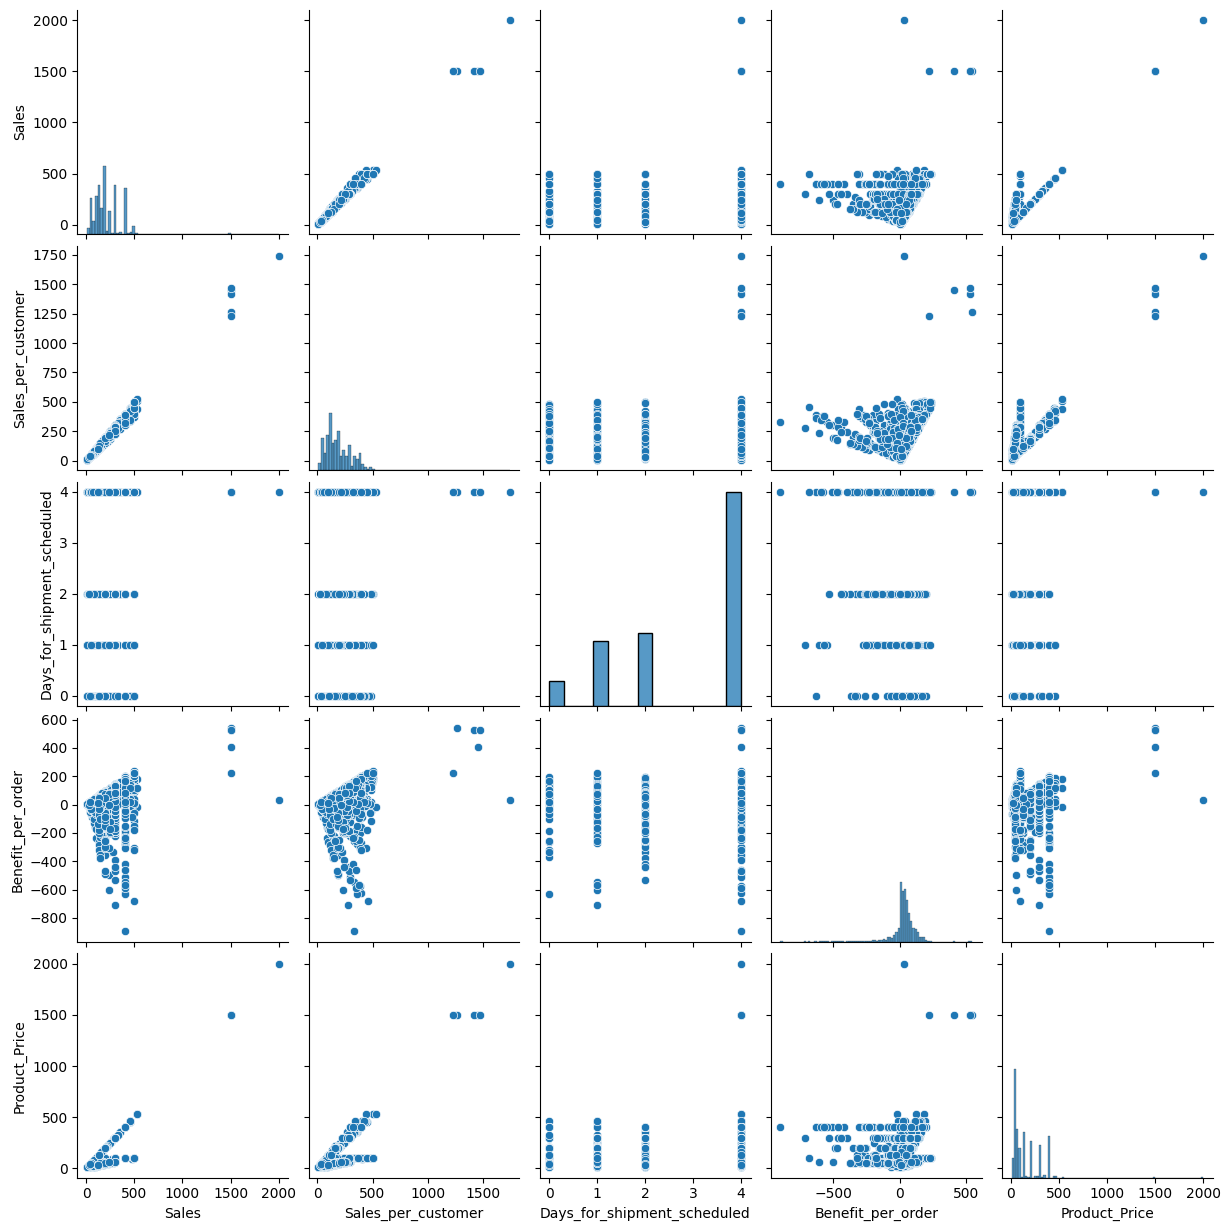

In [29]:
# Creating pairplot to have a variables behaviour visibility 
# 1. Select only the top variables that showed correlation or interest in the heatmap
top_vars = ['Sales', 'Sales_per_customer', 'Days_for_shipment_scheduled', 'Benefit_per_order', 'Product_Price']
# 2. Sample the data 2000 rows to make the pairplot more readable and faster to render
df_supply_sample = df_supply.sample(n= 2000, random_state= 42)
sns.pairplot(df_supply_sample[top_vars])

## 5.3 Final DataSet Columns
1. The "Baseline" Version (All Variables)
    - To see how KNN performs when it has access to every single data point, even the "noisy" ones like Sugar and pH.
    - **final_cols_base** = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality_bin']
2. The "Optimized" Version (Dropping Noise/Redundancy)
    - To see if accuracy increases when we remove Multicollinearity (Density/pH) and Low Correlation (Sugar).
    - final_cols_opt = ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol', 'quality_bin']

In [ ]:
final_cols_base = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality_bin']
final_cols_opt = ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol', 'quality_bin']

df_col_base = df[final_cols_base]
df_col_opt = df[final_cols_opt]

In [ ]:
print(tabulate(df_col_base.describe(), headers= "keys", tablefmt= "psql"))

In [ ]:
print(tabulate(df_col_opt.describe(), headers= "keys", tablefmt= "psql"))

# Step 6: Feature Engineering
## 6.1 Outlier analysis

In [ ]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(final_cols_base) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(final_cols_base):
    sns.boxplot(data= df_col_base, y= col, ax= axes[i], color= 'salmon')
for j in range(len(final_cols_base), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
- Those boxplots are the final "green light" we needed to proceed with the model. By visualizing the outliers so clearly, I’ve identified exactly where the KNN algorithm might get "pulled" in the wrong direction.

In [ ]:
# Necessary coding to replace outliers creating upper and lower limits
df_WITH_outliers_baseCol = df_col_base.copy()
df_WITHOUT_outliers_baseCol = df_col_base.copy()

df_WITH_outliers_optCol = df_col_opt.copy()
df_WITHOUT_outliers_optCol = df_col_opt.copy()

outliers_cols_base = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] # The target variable price can't be modified so we leave as it is.
outliers_cols_opt = ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']

def replace_outliers(column, data_df):
   col_stats = data_df[column].describe()
   col_iqr = col_stats["75%"] - col_stats["25%"]
   upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
   lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

   if lower_limit < 0: lower_limit = min(df[column])
   # Let's take out upper outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
   # Let's take out lower outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
   return data_df.copy(), [lower_limit, upper_limit]

outliers_dict_base = {}
for column in outliers_cols_base:
   df_WITHOUT_outliers_baseCol, limits = replace_outliers(column, df_WITHOUT_outliers_baseCol)
   outliers_dict_base.update({column: limits})

outliers_dict_opt= {}
for column in outliers_cols_opt:
   df_WITHOUT_outliers_optCol, limits = replace_outliers(column, df_WITHOUT_outliers_optCol)
   outliers_dict_opt.update({column: limits})

print(f"Limits using base columns: {outliers_dict_base}") # This jason needs to be saved
print(f"Limits using optimized columns: {outliers_dict_opt}") # This jason needs to be saved


In [ ]:
# Saving the json dictionary for outliers limit
with open('../data/interim/outliers_dict_base.json', 'w') as f:
     json.dump(outliers_dict_base, f)

with open('../data/interim/outliers_dict_opt.json', 'w') as f:
     json.dump(outliers_dict_opt, f)

## 6.2 Missing Value Analysis

In [ ]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers_baseCol.isnull().sum().sort_values(ascending= False))

In [ ]:
print("The list below, will show if dataset WITHOUT outliers has any null value for the variables:")
print(df_WITHOUT_outliers_baseCol.isnull().sum().sort_values(ascending= False))

## 6.3 Inference of New Features
* Proposed Engineering for Both Sets
    - The Acidity Index: Create a total_acidity column ($fixed + volatile + citric$).

In [ ]:
def apply_engineering(df_input, is_base= True):
    
    # Applied to both sets
    df_input['total_acidity'] = df_input['fixed acidity'] + df_input['volatile acidity'] + df_input['citric acid']
    
    return df_input

# Generate the new experimental sets
df_WITH_outliers_baseCol = apply_engineering(df_WITH_outliers_baseCol, is_base=True)
df_WITHOUT_outliers_baseCol = apply_engineering(df_WITHOUT_outliers_baseCol, is_base=True)

df_WITH_outliers_optCol = apply_engineering(df_WITH_outliers_optCol, is_base=False)
df_WITHOUT_outliers_optCol = apply_engineering(df_WITHOUT_outliers_optCol, is_base=False)

In [ ]:
# Creating << NEW >> heatmap chart to analyze complete variables correlation
cols_num = df_WITH_outliers_baseCol.select_dtypes(include= ['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_WITH_outliers_baseCol[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "coolwarm", ax= ax).tick_params(axis= 'x', rotation= 45)
plt.tight_layout()
plt.show()

### 6.3.1 Conclusion on New Features
1. The "Total Acidity" Stability
- total_acidity feature shows a strong $1.00$ correlation with fixed acidity and $0.69$ with citric acid.
    - The Strategy: This confirms that I can safely drop the three individual acid columns.

* **Given the conclusion above**,
    - **FINAL_COL_DATSET_BASE** = [total_acidity, residual sugar, total sulfur dioxide, chlorides, sulphates, alcohol, pH, density, quality_bin]
    - **FINAL_COL_DATSET_OPT** = [total_acidity, total sulfur dioxide, chlorides, sulphates, alcohol, quality_bin]

In [ ]:
FINAL_COL_DATSET_BASE = ['total_acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol', 'pH', 'density', 'quality_bin']
FINAL_COL_DATSET_OPT = ['total_acidity', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol', 'quality_bin']

df_WITH_outliers_baseCol = df_WITH_outliers_baseCol[FINAL_COL_DATSET_BASE]
df_WITHOUT_outliers_baseCol = df_WITHOUT_outliers_baseCol[FINAL_COL_DATSET_BASE]
df_WITH_outliers_optCol = df_WITH_outliers_optCol[FINAL_COL_DATSET_OPT]
df_WITHOUT_outliers_optCol = df_WITHOUT_outliers_optCol[FINAL_COL_DATSET_OPT]



## 6.4 Feature Scaling

In [ ]:
# Divide the set into train and test
				
predictors_base = ['total_acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol', 'pH', 'density']
predictors_opt = ['total_acidity', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol']
target = 'quality_bin'

X_WITH_outliers_baseCol = df_WITH_outliers_baseCol.drop(target, axis = 1)[predictors_base]
X_WITHOUT_outliers_baseCol = df_WITHOUT_outliers_baseCol.drop(target, axis = 1)[predictors_base]
X_WITH_outliers_optCol = df_WITH_outliers_optCol.drop(target, axis= 1)[predictors_opt]
X_WITHOUT_outliers_optCol = df_WITHOUT_outliers_optCol.drop(target, axis= 1)[predictors_opt]
y = df_WITH_outliers_baseCol[target]

X_train_WITH_outliers_baseCol, X_test_WITH_outliers_baseCol, y_train, y_test = train_test_split(X_WITH_outliers_baseCol, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers_baseCol, X_test_WITHOUT_outliers_baseCol = train_test_split(X_WITHOUT_outliers_baseCol, test_size = 0.2, random_state = 10)
X_train_WITH_outliers_optCol, X_test_WITH_outliers_optCol, y_train, y_test = train_test_split(X_WITH_outliers_optCol, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers_optCol, X_test_WITHOUT_outliers_optCol = train_test_split(X_WITHOUT_outliers_optCol, test_size = 0.2, random_state = 10)

In [ ]:
# Normalization and MIN_MAX Scaling
# X_train_WITH_outliers_baseCol 
# X_train_WITHOUT_outliers_baseCol 
# X_train_WITH_outliers_optCol
# X_train_WITHOUT_outliers_optCol

# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
# Base Columns
norm_WITH_outliers_baseCol = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale.
# .fit(), The "Learning"
norm_WITH_outliers_baseCol.fit(X_train_WITH_outliers_baseCol) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.
# Opt. Columns
norm_WITH_outliers_optCol = StandardScaler()
norm_WITH_outliers_optCol.fit(X_train_WITH_outliers_optCol)

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
# Base Columns
X_train_WITH_outliers_baseCol_norm = norm_WITH_outliers_baseCol.transform(X_train_WITH_outliers_baseCol) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_baseCol_norm = pd.DataFrame(X_train_WITH_outliers_baseCol_norm, index = X_train_WITH_outliers_baseCol.index, columns = predictors_base) # We need to convert to DataFrame the transform with this variable
X_test_WITH_outliers_baseCol_norm = norm_WITH_outliers_baseCol.transform(X_test_WITH_outliers_baseCol)
X_test_WITH_outliers_baseCol_norm = pd.DataFrame(X_test_WITH_outliers_baseCol_norm, index = X_test_WITH_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITH_outliers_optCol_norm = norm_WITH_outliers_optCol.transform(X_train_WITH_outliers_optCol)
X_train_WITH_outliers_optCol_norm = pd.DataFrame(X_train_WITH_outliers_optCol_norm, index = X_train_WITH_outliers_optCol.index, columns = predictors_opt)
X_test_WITH_outliers_optCol_norm = norm_WITH_outliers_optCol.transform(X_test_WITH_outliers_optCol)
X_test_WITH_outliers_optCol_norm = pd.DataFrame(X_test_WITH_outliers_optCol_norm, index = X_test_WITH_outliers_optCol.index, columns = predictors_opt)

### WITHOUT OUTLIERS
# Base Columns
norm_WITHOUT_outliers_baseCol = StandardScaler()
norm_WITHOUT_outliers_baseCol.fit(X_train_WITHOUT_outliers_baseCol)
# Opt. Columns
norm_WITHOUT_outliers_optCol = StandardScaler()
norm_WITHOUT_outliers_optCol.fit(X_train_WITHOUT_outliers_optCol)
# Base Columns
X_train_WITHOUT_outliers_baseCol_norm = norm_WITHOUT_outliers_baseCol.transform(X_train_WITHOUT_outliers_baseCol)
X_train_WITHOUT_outliers_baseCol_norm = pd.DataFrame(X_train_WITHOUT_outliers_baseCol_norm, index = X_train_WITHOUT_outliers_baseCol.index, columns = predictors_base)
X_test_WITHOUT_outliers_baseCol_norm = norm_WITHOUT_outliers_baseCol.transform(X_test_WITHOUT_outliers_baseCol)
X_test_WITHOUT_outliers_baseCol_norm = pd.DataFrame(X_test_WITHOUT_outliers_baseCol_norm, index = X_test_WITHOUT_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITHOUT_outliers_optCol_norm = norm_WITHOUT_outliers_optCol.transform(X_train_WITHOUT_outliers_optCol)
X_train_WITHOUT_outliers_optCol_norm = pd.DataFrame(X_train_WITHOUT_outliers_optCol_norm, index = X_train_WITHOUT_outliers_optCol.index, columns = predictors_opt)
X_test_WITHOUT_outliers_optCol_norm = norm_WITHOUT_outliers_optCol.transform(X_test_WITHOUT_outliers_optCol)
X_test_WITHOUT_outliers_optCol_norm = pd.DataFrame(X_test_WITHOUT_outliers_optCol_norm, index = X_test_WITHOUT_outliers_optCol.index, columns = predictors_opt)


## SCALED MIN_MAX
### WITH OUTLIERS
# Base Columns
scaler_WITH_outliers_baseCol = MinMaxScaler() # MinMaxScaler() is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers_baseCol.fit(X_train_WITH_outliers_baseCol)
# Opt. Columns
scaler_WITH_outliers_optCol = MinMaxScaler() # MinMaxScaler() is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers_optCol.fit(X_train_WITH_outliers_optCol)
# Base Columns
X_train_WITH_outliers_baseCol_scal = scaler_WITH_outliers_baseCol.transform(X_train_WITH_outliers_baseCol)
X_train_WITH_outliers_baseCol_scal = pd.DataFrame(X_train_WITH_outliers_baseCol_scal, index = X_train_WITH_outliers_baseCol.index, columns = predictors_base)
X_test_WITH_outliers_baseCol_scal = scaler_WITH_outliers_baseCol.transform(X_test_WITH_outliers_baseCol)
X_test_WITH_outliers_baseCol_scal = pd.DataFrame(X_test_WITH_outliers_baseCol_scal, index = X_test_WITH_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITH_outliers_optCol_scal = scaler_WITH_outliers_optCol.transform(X_train_WITH_outliers_optCol)
X_train_WITH_outliers_optCol_scal = pd.DataFrame(X_train_WITH_outliers_optCol_scal, index = X_train_WITH_outliers_optCol.index, columns = predictors_opt)
X_test_WITH_outliers_optCol_scal = scaler_WITH_outliers_optCol.transform(X_test_WITH_outliers_optCol)
X_test_WITH_outliers_optCol_scal = pd.DataFrame(X_test_WITH_outliers_optCol_scal, index = X_test_WITH_outliers_optCol.index, columns = predictors_opt)

### WITHOUT OUTLIERS
# Base Columns
scaler_WITHOUT_outliers_baseCol = MinMaxScaler()
scaler_WITHOUT_outliers_baseCol.fit(X_train_WITHOUT_outliers_baseCol)
# Opt. Columns
scaler_WITHOUT_outliers_optCol = MinMaxScaler()
scaler_WITHOUT_outliers_optCol.fit(X_train_WITHOUT_outliers_optCol)
# Base Columns
X_train_WITHOUT_outliers_baseCol_scal = scaler_WITHOUT_outliers_baseCol.transform(X_train_WITHOUT_outliers_baseCol)
X_train_WITHOUT_outliers_baseCol_scal = pd.DataFrame(X_train_WITHOUT_outliers_baseCol_scal, index = X_train_WITHOUT_outliers_baseCol.index, columns = predictors_base)
X_test_WITHOUT_outliers_baseCol_scal = scaler_WITHOUT_outliers_baseCol.transform(X_test_WITHOUT_outliers_baseCol)
X_test_WITHOUT_outliers_baseCol_scal = pd.DataFrame(X_test_WITHOUT_outliers_baseCol_scal, index = X_test_WITHOUT_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITHOUT_outliers_optCol_scal = scaler_WITHOUT_outliers_optCol.transform(X_train_WITHOUT_outliers_optCol)
X_train_WITHOUT_outliers_optCol_scal = pd.DataFrame(X_train_WITHOUT_outliers_optCol_scal, index = X_train_WITHOUT_outliers_optCol.index, columns = predictors_opt)
X_test_WITHOUT_outliers_optCol_scal = scaler_WITHOUT_outliers_optCol.transform(X_test_WITHOUT_outliers_optCol)
X_test_WITHOUT_outliers_optCol_scal = pd.DataFrame(X_test_WITHOUT_outliers_optCol_scal, index = X_test_WITHOUT_outliers_optCol.index, columns = predictors_opt)

### 6.4.1 Testing Data Consistency

In [ ]:
print("Table with train data modified WITH outliers and baseCol.")
print(tabulate(X_train_WITH_outliers_baseCol_norm.head(), headers= "keys", tablefmt= "psql"))

In [ ]:
print("Table with train data modified WITH outliers and optCol. Normalization of the data embedded.")
print(tabulate(X_train_WITHOUT_outliers_optCol_norm.head(), headers= "keys", tablefmt= "psql"))

### 6.4.2 Saving all of the DATASET
    train, test with all the variance we have created.

In [ ]:
# DATASETS that have been created so far in previous steps from the feature engineering
# BaseCol
X_train_WITH_outliers_baseCol.to_excel("../data/processed/X_train_WITH_outliers_baseCol.xlsx", index = False)
X_train_WITH_outliers_baseCol_norm.to_excel("../data/processed/X_train_WITH_outliers_baseCol_norm.xlsx", index = False)
X_train_WITH_outliers_baseCol_scal.to_excel("../data/processed/X_train_WITH_outliers_baseCol_scal.xlsx", index = False)
X_train_WITHOUT_outliers_baseCol.to_excel("../data/processed/X_train_WITHOUT_outliers_baseCol.xlsx", index = False)
X_train_WITHOUT_outliers_baseCol_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_baseCol_norm.xlsx", index = False)
X_train_WITHOUT_outliers_baseCol_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_baseCol_scal.xlsx", index = False)

X_test_WITH_outliers_baseCol.to_excel("../data/processed/X_test_WITH_outliers_baseCol.xlsx", index = False)
X_test_WITH_outliers_baseCol_norm.to_excel("../data/processed/X_test_WITH_outliers_baseCol_norm.xlsx", index = False)
X_test_WITH_outliers_baseCol_scal.to_excel("../data/processed/X_test_WITH_outliers_baseCol_scal.xlsx", index = False)
X_test_WITHOUT_outliers_baseCol.to_excel("../data/processed/X_test_WITHOUT_outliers_baseCol.xlsx", index = False)
X_test_WITHOUT_outliers_baseCol_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_baseCol_norm.xlsx", index = False)
X_test_WITHOUT_outliers_baseCol_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_baseCol_scal.xlsx", index = False)

# OptCol
X_train_WITH_outliers_optCol.to_excel("../data/processed/X_train_WITH_outliers_optCol.xlsx", index = False)
X_train_WITH_outliers_optCol_norm.to_excel("../data/processed/X_train_WITH_outliers_optCol_norm.xlsx", index = False)
X_train_WITH_outliers_optCol_scal.to_excel("../data/processed/X_train_WITH_outliers_optCol_scal.xlsx", index = False)
X_train_WITHOUT_outliers_optCol.to_excel("../data/processed/X_train_WITHOUT_outliers_optCol.xlsx", index = False)
X_train_WITHOUT_outliers_optCol_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_optCol_norm.xlsx", index = False)
X_train_WITHOUT_outliers_optCol_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_optCol_scal.xlsx", index = False)

X_test_WITH_outliers_optCol.to_excel("../data/processed/X_test_WITH_outliers_optCol.xlsx", index = False)
X_test_WITH_outliers_optCol_norm.to_excel("../data/processed/X_test_WITH_outliers_optCol_norm.xlsx", index = False)
X_test_WITH_outliers_optCol_scal.to_excel("../data/processed/X_test_WITH_outliers_optCol_scal.xlsx", index = False)
X_test_WITHOUT_outliers_optCol.to_excel("../data/processed/X_test_WITHOUT_outliers_optCol.xlsx", index = False)
X_test_WITHOUT_outliers_optCol_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_optCol_norm.xlsx", index = False)
X_test_WITHOUT_outliers_optCol_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_optCol_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers_baseCol, file)
with open("../models/norm_WITH_outliers_optCol.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers_optCol, file)
with open("../models/norm_WITHOUT_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers_baseCol, file)
with open("../models/norm_WITHOUT_outliers_optCol.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers_optCol, file)
with open("../models/scaler_WITH_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers_baseCol, file)
with open("../models/scaler_WITH_outliers_optCol.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers_optCol, file)
with open("../models/scaler_WITHOUT_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers_baseCol, file)
with open("../models/scaler_WITHOUT_outliers_optCol.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers_optCol, file)

# Step 7. Feature Selection
    - Test all dataset "roughly" and I will keep the best score. Keeping all variable.
    - The model need to be trained entirely.
    - If results meet desire objective --> YEAH! WE?VE FINISHED.
    - If not, move back to step 6 and repeat the process from step 2.

* **IMPORTANT MESSAGE**: 
- Although I have runned the feature selection to check best freatures or variable using SelectKBest, I will run my KNN model with the base al optimized columns define before to compare Accuracy
- For a better training an practicing and checking if the Accuracy of the KNN model cqan be improved, I might go back to this point of feature selection and try running the model with SelectKBest.
- Thank you all for your understanding.

# Step 8. Best Model Selection

In [ ]:
datasets_base = [
    X_train_WITH_outliers_baseCol,
    X_train_WITH_outliers_baseCol_norm,
    X_train_WITH_outliers_baseCol_scal,
    X_train_WITHOUT_outliers_baseCol,
    X_train_WITHOUT_outliers_baseCol_norm,
    X_train_WITHOUT_outliers_baseCol_scal,
    ]

datasets_opt = [
    X_train_WITH_outliers_optCol,
    X_train_WITH_outliers_optCol_norm,
    X_train_WITH_outliers_optCol_scal,
    X_train_WITHOUT_outliers_optCol,
    X_train_WITHOUT_outliers_optCol_norm,
    X_train_WITHOUT_outliers_optCol_scal,
    ]

models_base = []
metrics_base = []
for dataset in datasets_base:
  model = KNeighborsClassifier() # KNN model
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = accuracy_score(y_train, y_pred)
  metrics_base.append(metric)
  models_base.append(model)

best_metric_base = max(metrics_base)
best_index_base = metrics_base.index(best_metric_base)
print(f"This is the list of accu. score: {metrics_base}\nThe best metric: {best_metric_base}\nThe Best index: {best_index_base}")
print("The best DataSet is: ", datasets_base[best_index_base])

In [ ]:

models_opt = []
metrics_opt = []
for dataset in datasets_opt:
  model = KNeighborsClassifier()
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = accuracy_score(y_train, y_pred)
  metrics_opt.append(metric)
  models_opt.append(model)

best_metric_opt = max(metrics_opt)
best_index_opt = metrics_opt.index(best_metric_opt)
print(f"This is the list of accu. score: {metrics_opt}\nThe best metric: {best_metric_opt}\nThe Best index: {best_index_opt}")
print("The best DataSet is: ", datasets_opt[best_index_opt])

## 8.1 Evaluate Performance on the Test Set

In [ ]:
# 1. Using the 'Champion' data (Index 4 for base from the list)
# Let's assume you're using the Normalized (StandardScaler) version
knn_base = KNeighborsClassifier()
knn_base.fit(X_train_WITHOUT_outliers_baseCol_norm, y_train)

# 2. Predict on the unseen Test Set
y_pred_base = knn_base.predict(X_test_WITHOUT_outliers_baseCol_norm)

# 3. Create the Matrix
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Low Quality', 'High Quality'])

# Plotting
plt.figure(figsize=(8, 6))
disp.plot(cmap= 'Blues')
plt.title('Model with base Columns selection: Confusion Matrix')
plt.show()

# 4. Detailed Report
print(classification_report(y_test, y_pred_base))

In [ ]:
# 1. Using the 'Champion' data (Index 2 for optimized from the list)
knn_opt = KNeighborsClassifier()
knn_opt.fit(X_train_WITH_outliers_optCol_scal, y_train)

# 2. Predict on the unseen Test Set
y_pred_opt = knn_opt.predict(X_test_WITH_outliers_optCol_scal)

# 3. Create the Matrix
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Low Quality', 'High Quality'])

# Plotting
plt.figure(figsize=(8, 6))
disp.plot(cmap= 'Blues')
plt.title('Model with optimized Columns selection: Confusion Matrix')
plt.show()

# 4. Detailed Report
print(classification_report(y_test, y_pred_opt))

# Step 9. Optimize k.
- Create a loop to test different k values (e.g., from 1 to 20).

In [ ]:
# 1. Initialize lists to store our results
k_values = range(1, 21, 2) # Testing 1, 3, 5, ..., 19
accuracies = []

# 2. The Loop
for k in k_values:
    # Initialize model with current k
    knn = KNeighborsClassifier(n_neighbors= k)
    
    # Fit using the best training data
    knn.fit(X_train_WITH_outliers_optCol_scal, y_train)
    
    # Predict and calculate accuracy
    y_pred = knn.predict(X_test_WITH_outliers_optCol_scal)
    acc = accuracy_score(y_test, y_pred)
    
    # Save the result
    accuracies.append(acc)

# Find the best K and its accuracy
best_acc = max(accuracies)
best_k = k_values[accuracies.index(best_acc)]

print(f"The optimal value is k = {best_k} with an accuracy of {best_acc:.4f}")

## 9.1 Plot Accuracy vs k (Find the best value)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor= 'red', markersize= 8)

plt.title('Accuracy Score vs. K Value (Optimized Dataset)')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.xticks(k_values)
plt.grid(True, linestyle= '--', alpha= 0.7)

# Highlight the best K. For more info--> https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_basic.html
plt.annotate(f'Best K: {best_k}', xy= (best_k, best_acc), xytext= (best_k+1, best_acc), arrowprops= dict(facecolor= 'black', shrink= 0.05))

plt.show()

### 9.1.1 Conclusion on K Value Chart
- To optimize the model, I tested $k$ values from 1 to 20.
- The K Value range I have adjusted the step to "2" avoiding having tight voting when the number is even.
- The results indicate that $k=17$ is the optimal hyperparameter. 
- Beyond this point, accuracy declines as the model begins to underfit, incorporating irrelevant neighbors into the classification decision.

In [ ]:
# Final "Champion" Model
final_knn = KNeighborsClassifier(n_neighbors= 17)
final_knn.fit(X_train_WITH_outliers_optCol_scal, y_train)

y_pred_final = final_knn.predict(X_test_WITH_outliers_optCol_scal)

print(f"Final Optimized Accuracy with k=17: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final))

## 9.2 Save the Final Model

In [ ]:
# 1. Save the KNN Model
with open("../models/champion_knn_model.pkl", "wb") as file:
    pickle.dump(final_knn, file)

print("Champion Model and Scaler have been saved to the /models/ folder!")

# Step 10. Feeling Confident (test the model)

In [ ]:
def predict_wine_quality(input_list):
    """ Takes 11 raw features, engineers 'total_acidity', selects the best features, and predicts.   """
    # 1. I will map the 11 inputs to column names
    all_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 
                'density', 'pH', 'sulphates', 'alcohol']
    
    df_input = pd.DataFrame([input_list], columns= all_cols)
    
    # 2. FEATURE ENGINEERING: Recreate 'total_acidity' as I did in the EDA
    # This must match exactly how I did it during training
    df_input['total_acidity'] = (df_input['fixed acidity'] + 
                                 df_input['volatile acidity'] + 
                                 df_input['citric acid'])
    
    # 3. I select the Top 5 Winning Columns
    winning_cols = ['total_acidity', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol']
    df_final = df_input[winning_cols]
    
    # 4. SCALE the data using the Champion Scaler (MinMax) saved before
    X_scaled = scaler_WITH_outliers_optCol.transform(df_final)
    X_scaled = pd.DataFrame(X_scaled, index= df_final.index, columns= winning_cols)
    
    # 5. VAMOSS!! PREDICT
    prediction = final_knn.predict(X_scaled)[0]
    
    # 6. RETURN Result
    if prediction == 1:
        return "This wine is likely of HIGH quality! 🍷✨"
    else:
        return "This wine is likely of medium/low quality. 🍷"

# --- TEST ---
# Standard wine input (11 values) as per 4GeeksAcademy
test_wine = [7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
print(predict_wine_quality(test_wine))